# Discrete Flow Matching para una Distribución en Espiral
En este notebook implementaremos un modelo de Discrete Flow Matching (DFM) para transformar ruido aleatorio en puntos que formen una distribución en espiral discreta.

## 1. Generación de la distribución en espiral
Primero, generaremos una nube de puntos que sigan una espiral en 2D.

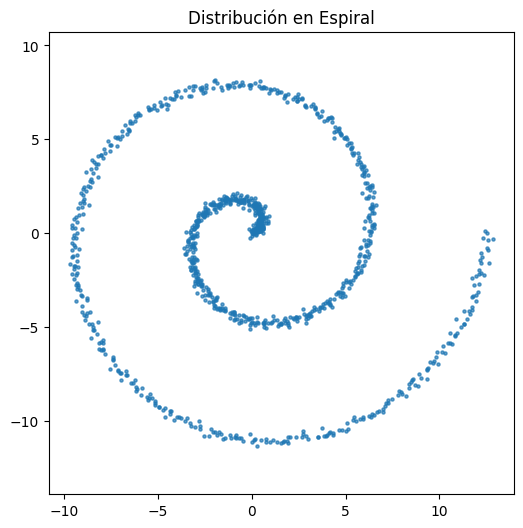

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de la espiral
def make_spiral(n_points=1000, noise=0.1):
    t = np.linspace(0, 4 * np.pi, n_points)
    x = t * np.cos(t)
    y = t * np.sin(t)
    X = np.stack([x, y], axis=1)
    X += noise * np.random.randn(*X.shape)
    return X

spiral = make_spiral(n_points=1000, noise=0.15)
plt.figure(figsize=(6,6))
plt.scatter(spiral[:,0], spiral[:,1], s=5, alpha=0.7)
plt.title('Distribución en Espiral')
plt.axis('equal')
plt.show()

## 2. Definición del modelo de Discrete Flow Matching
Utilizaremos una red neuronal simple para aproximar el campo de velocidades entre el ruido y la espiral.

In [10]:
import torch
import torch.nn as nn

dim = 2

class SimpleMLP(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim+1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, dim)
        )
    def forward(self, x, t):
        # x: [batch, dim], t: [batch, 1]
        xt = torch.cat([x, t], dim=1)
        return self.net(xt)

## 3. Entrenamiento del modelo DFM
Entrenaremos el modelo para aprender a transformar ruido gaussiano en la espiral.

In [11]:
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(0)
X_target = torch.tensor(spiral, dtype=torch.float32)
N = X_target.shape[0]

# Ruido inicial
def sample_noise(n):
    return torch.randn(n, dim)

# Dataset para entrenamiento
dataset = TensorDataset(X_target)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

model = SimpleMLP(dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
import copy

n_steps_1 = 1000
for step in range(n_steps_1):
    for batch, in dataloader:
        batch_size = batch.shape[0]
        t = torch.rand(batch_size, 1)  # t ~ Uniform[0,1]
        x0 = sample_noise(batch_size)
        x1 = batch
        x_t = t * x1 + (1 - t) * x0
        v_target = x1 - x0
        v_pred = model(x_t, t)
        loss = ((v_pred - v_target) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if step % 100 == 0:
        print(f"Paso {step}, pérdida: {loss.item():.4f}")
        
# Guardar modelo tras 1000 pasos
model_1000 = copy.deepcopy(model)

Paso 0, pérdida: 8.7045
Paso 100, pérdida: 8.3913
Paso 200, pérdida: 6.8292
Paso 300, pérdida: 7.3940
Paso 400, pérdida: 7.2710
Paso 500, pérdida: 7.4031
Paso 600, pérdida: 7.2470
Paso 700, pérdida: 8.6507
Paso 800, pérdida: 6.2890
Paso 900, pérdida: 6.1881


In [ ]:
n_steps_2 = 100000 - n_steps_1
for step in range(n_steps_2):
    for batch, in dataloader:
        batch_size = batch.shape[0]
        t = torch.rand(batch_size, 1)
        x0 = sample_noise(batch_size)
        x1 = batch
        x_t = t * x1 + (1 - t) * x0
        v_target = x1 - x0
        v_pred = model(x_t, t)
        loss = ((v_pred - v_target) ** 2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if step % 10000 == 0:
        print(f"Paso {step+n_steps_1}, pérdida: {loss.item():.4f}")

# Guardar modelo tras 100000 pasos
model_100000 = model

Paso 1000, pérdida: 6.0110
Paso 11000, pérdida: 7.6534


## 4. Muestreo: Generar la espiral a partir de ruido
Usamos el modelo entrenado para transformar ruido en la espiral mediante integración hacia adelante.

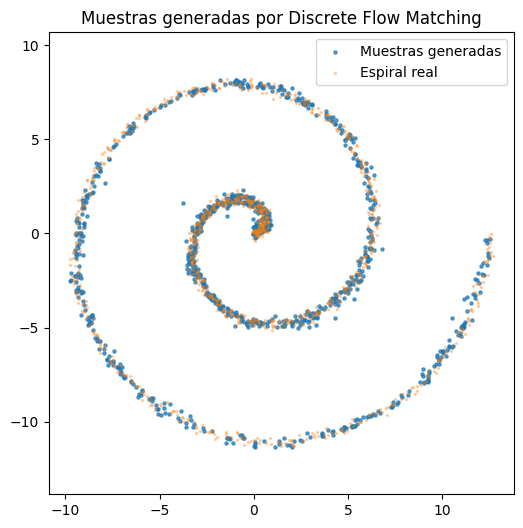

In [ ]:
@torch.no_grad()
def sample_flow(model, n_samples=1000, n_steps=50):
    x = sample_noise(n_samples)
    t_steps = torch.linspace(0, 1, n_steps+1)
    for i in range(n_steps):
        t = t_steps[i].repeat(n_samples, 1)
        v = model(x, t)
        dt = t_steps[i+1] - t_steps[i]
        x = x + v * dt
    return x.numpy()

samples = sample_flow(model_100000, n_samples=1000, n_steps=100)
plt.figure(figsize=(6,6))
plt.scatter(samples[:,0], samples[:,1], s=5, alpha=0.7, label='Muestras generadas')
plt.scatter(spiral[:,0], spiral[:,1], s=2, alpha=0.3, label='Espiral real')
plt.legend()
plt.title('Muestras generadas por Discrete Flow Matching')
plt.axis('equal')
plt.show()

In [ ]:
# Muestreo con ambos modelos
samples_1000 = sample_flow(model_1000, n_samples=1000, n_steps=100)
samples_100000 = sample_flow(model_100000, n_samples=1000, n_steps=100)

# Visualización comparativa
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(samples_1000[:,0], samples_1000[:,1], s=5, alpha=0.7, label='Generadas (1000 pasos)')
plt.scatter(spiral[:,0], spiral[:,1], s=2, alpha=0.3, label='Espiral real')
plt.title('Muestras tras 1000 pasos')
plt.axis('equal')
plt.legend()

plt.subplot(1,2,2)
plt.scatter(samples_100000[:,0], samples_100000[:,1], s=5, alpha=0.7, label='Generadas (100000 pasos)')
plt.scatter(spiral[:,0], spiral[:,1], s=2, alpha=0.3, label='Espiral real')
plt.title('Muestras tras 100000 pasos')
plt.axis('equal')
plt.legend()
plt.show()

## 5. Conclusión
Hemos implementado Discrete Flow Matching para transformar ruido en una distribución en espiral discreta. El modelo aprende a aproximar el campo de velocidades óptimo para mapear el ruido a la espiral.